# Install the `alchemy` library from github

... and dependencies

In [1]:
!pip install -q tqdm
!git clone https://git@github.com/wenkesj/alchemy.git
!(cd ~/alchemy; pip install -q .)

fatal: destination path '/content/alchemy' already exists and is not an empty directory.


# Create the Models
Create a template in order to compare different `RNNCell`s with the same baseline.

In [0]:
import tensorflow as tf
import alchemy

def model_fn(cell, inputs_ph, targets_ph, vocab_size,
             hidden_layers=[50],
             embedding_size=50,
             learning_rate=6.25e-5,
             grad_clip=5.):
  embedding = tf.get_variable("embedding", [vocab_size, embedding_size])
  inputs = tf.nn.embedding_lookup(embedding, inputs_ph)

  state = cell.zero_state(tf.shape(inputs)[0], dtype=inputs.dtype)
  for input in tf.unstack(inputs, axis=1):
    outputs, state = cell(input, state)

  target_size = targets_ph.get_shape().as_list()[-1]
  logits = outputs
  if hidden_layers:
    for num_units in hidden_layers:
      logits = tf.layers.dense(logits, num_units, activation=tf.nn.relu)
    logits = tf.layers.dense(logits, target_size)

  probs = tf.nn.softmax(logits)
  loss = tf.reduce_mean(
      -tf.reduce_sum(
          tf.log(probs) * tf.cast(targets_ph, tf.float32), axis=-1))

  vars = tf.trainable_variables()
  grads = tf.gradients(loss, vars)
  if grad_clip:
    grads, _ = tf.clip_by_global_norm(grads, grad_clip)
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
  train_op = optimizer.apply_gradients(zip(grads, vars))

  accuracy = tf.reduce_mean(tf.cast(
      tf.equal(
          tf.argmax(probs, axis=-1), 
          tf.argmax(targets_ph, axis=-1)), 
      tf.float32))

  return loss, train_op, accuracy

# Prepare the Associative Retrieval Task (ART) Dataset

In [0]:
import numpy as np

def dataset_fn(dataset, k, sequence_length, target_length, batch_size):
  def stream():
    while True:
      x, y = dataset.create_example(k=k)
      yield np.argmax(x, -1), y

  dtypes_and_shapes = [
      (tf.int32, [sequence_length]), # x
      (tf.int32, [target_length]), # y
  ]

  ds = tf.data.Dataset.from_generator(stream, *zip(*dtypes_and_shapes))
  ds = ds.batch(batch_size)
  iterator = ds.make_one_shot_iterator()

  return iterator.get_next()

k = 6
batch_size = 256

dataset = alchemy.contrib.data.ART()
x, y = dataset.create_example(k=k)

sequence_length = len(x)
vocab_size = len(x[0])
target_length = len(y)

# Train/Validation Loop

In [0]:
import sys
from tqdm import trange

epochs = 75
num_iters = 50
learning_rate = 1e-3
grad_clip = None
train_msg = 'epoch {} loss: {:.5f}'

def train_fn(cell):
  tf.reset_default_graph()
  tf.set_random_seed(42)
  np.random.seed(42)

  dataset = alchemy.contrib.data.ART()
  x_op, y_op = dataset_fn(
      dataset, k, sequence_length, target_length, batch_size)

  inputs_ph = tf.placeholder(tf.int32, [None, sequence_length])
  targets_ph = tf.placeholder(tf.int32, [None, target_length])

  loss_op, train_op, accuracy_op = model_fn(
      cell, inputs_ph, targets_ph, vocab_size, 
      learning_rate=learning_rate, 
      grad_clip=grad_clip)

  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    accuracies = []
    for epoch in range(epochs):
      train_range = trange(
        num_iters, 
        desc=train_msg.format(epoch, 0.),
        file=sys.stdout)
      for _ in train_range:
        inputs, targets = sess.run((x_op, y_op))
        loss, _ = sess.run(
            (loss_op, train_op),
            feed_dict={
                inputs_ph: inputs,
                targets_ph: targets,
            })
        train_range.set_description(train_msg.format(epoch, loss))

      total_accuracy = 0
      for _ in range(num_iters):
        inputs, targets = sess.run((x_op, y_op))
        accuracy = sess.run(
            accuracy_op,
            feed_dict={
                inputs_ph: inputs,
                targets_ph: targets,
            })
        total_accuracy += accuracy
      total_accuracy = (total_accuracy / num_iters) * 100.
      print("Accuracy after epoch {}: {:.2f}%".format(epoch, total_accuracy))
      accuracies.append(total_accuracy)
    return accuracies

# Choose `RNNCell`s to test

In [0]:
num_units = 50

cells = [
    alchemy.contrib.rnn.FastWeightsRNNCell(
        num_units,
        fast_learning_rate=1.,
        fast_decay_rate=.9),
    tf.contrib.rnn.BasicRNNCell(num_units),
    alchemy.contrib.rnn.FastWeightsLSTMCell(
        num_units,
        fast_learning_rate=1.,
        fast_decay_rate=.9),
    tf.contrib.rnn.BasicLSTMCell(num_units),
]

# Train, Validate, and Compare (Plot)

epoch 0 loss: 2.00599: 100%|██████████| 50/50 [00:09<00:00,  5.42it/s]
Accuracy after epoch 0: 36.02%
epoch 1 loss: 1.45835: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]
Accuracy after epoch 1: 42.08%
epoch 2 loss: 1.21505: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]
Accuracy after epoch 2: 43.72%
epoch 3 loss: 1.18721: 100%|██████████| 50/50 [00:08<00:00,  6.00it/s]
Accuracy after epoch 3: 43.34%
epoch 4 loss: 1.17374:  18%|█▊        | 9/50 [00:01<00:06,  6.10it/s]

epoch 4 loss: 1.17300: 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]
Accuracy after epoch 4: 42.55%
epoch 5 loss: 1.12678: 100%|██████████| 50/50 [00:08<00:00,  6.04it/s]
Accuracy after epoch 5: 42.62%
epoch 6 loss: 1.09421: 100%|██████████| 50/50 [00:08<00:00,  6.07it/s]
Accuracy after epoch 6: 42.83%
epoch 7 loss: 1.07686: 100%|██████████| 50/50 [00:08<00:00,  6.05it/s]
Accuracy after epoch 7: 42.77%
epoch 8 loss: 1.07936:  20%|██        | 10/50 [00:01<00:06,  6.14it/s]

epoch 8 loss: 1.10187: 100%|██████████| 50/50 [00:08<00:00,  6.08it/s]
Accuracy after epoch 8: 42.55%
epoch 9 loss: 1.07978: 100%|██████████| 50/50 [00:08<00:00,  5.96it/s]
Accuracy after epoch 9: 42.42%
epoch 10 loss: 1.06340: 100%|██████████| 50/50 [00:08<00:00,  6.06it/s]
Accuracy after epoch 10: 42.56%
epoch 11 loss: 1.04802: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]
Accuracy after epoch 11: 42.66%
epoch 12 loss: 1.04088:  20%|██        | 10/50 [00:01<00:06,  5.93it/s]

epoch 12 loss: 0.98310: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]
Accuracy after epoch 12: 43.51%
epoch 13 loss: 1.01132: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]
Accuracy after epoch 13: 43.74%
epoch 14 loss: 1.01556: 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]
Accuracy after epoch 14: 42.82%
epoch 15 loss: 1.05373: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]
Accuracy after epoch 15: 43.42%
epoch 16 loss: 1.07637:  16%|█▌        | 8/50 [00:01<00:08,  5.17it/s]

epoch 16 loss: 1.04055: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]
Accuracy after epoch 16: 43.23%
epoch 17 loss: 1.03094: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]
Accuracy after epoch 17: 43.04%
epoch 18 loss: 0.99412: 100%|██████████| 50/50 [00:08<00:00,  5.83it/s]
Accuracy after epoch 18: 42.73%
epoch 19 loss: 1.06638: 100%|██████████| 50/50 [00:08<00:00,  5.95it/s]
Accuracy after epoch 19: 42.41%
epoch 20 loss: 1.00728:  16%|█▌        | 8/50 [00:01<00:07,  5.27it/s]

epoch 20 loss: 1.00919: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]
Accuracy after epoch 20: 43.12%
epoch 21 loss: 0.97489: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]
Accuracy after epoch 21: 43.05%
epoch 22 loss: 0.99476: 100%|██████████| 50/50 [00:08<00:00,  5.74it/s]
Accuracy after epoch 22: 43.28%
epoch 23 loss: 0.98325: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]
Accuracy after epoch 23: 43.91%
epoch 24 loss: 0.94919:  16%|█▌        | 8/50 [00:01<00:08,  5.13it/s]

epoch 24 loss: 0.97602: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]
Accuracy after epoch 24: 43.10%
epoch 25 loss: 0.98462: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]
Accuracy after epoch 25: 43.04%
epoch 26 loss: 0.95681: 100%|██████████| 50/50 [00:08<00:00,  5.79it/s]
Accuracy after epoch 26: 45.48%
epoch 27 loss: 0.94540: 100%|██████████| 50/50 [00:08<00:00,  5.81it/s]
Accuracy after epoch 27: 45.48%
epoch 28 loss: 1.00244:  16%|█▌        | 8/50 [00:01<00:07,  5.26it/s]

epoch 28 loss: 0.97514: 100%|██████████| 50/50 [00:08<00:00,  5.78it/s]
Accuracy after epoch 28: 46.43%
epoch 29 loss: 0.92460: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]
Accuracy after epoch 29: 49.64%
epoch 30 loss: 0.71614: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]
Accuracy after epoch 30: 65.88%
epoch 31 loss: 0.53650: 100%|██████████| 50/50 [00:08<00:00,  5.76it/s]
Accuracy after epoch 31: 76.16%
epoch 32 loss: 0.42865:  16%|█▌        | 8/50 [00:01<00:08,  5.22it/s]

epoch 32 loss: 0.26733: 100%|██████████| 50/50 [00:08<00:00,  5.77it/s]
Accuracy after epoch 32: 88.09%
epoch 33 loss: 0.19391: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]
Accuracy after epoch 33: 92.39%
epoch 34 loss: 0.15253: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]
Accuracy after epoch 34: 94.69%
epoch 35 loss: 0.08265: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]
Accuracy after epoch 35: 95.67%
epoch 36 loss: 0.12586:  16%|█▌        | 8/50 [00:01<00:07,  5.27it/s]

epoch 36 loss: 0.10881: 100%|██████████| 50/50 [00:08<00:00,  5.80it/s]
Accuracy after epoch 36: 96.67%
epoch 37 loss: 0.07098: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]
Accuracy after epoch 37: 97.06%
epoch 38 loss: 0.05137: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]
Accuracy after epoch 38: 97.84%
epoch 39 loss: 0.07416: 100%|██████████| 50/50 [00:08<00:00,  5.94it/s]
Accuracy after epoch 39: 97.59%
epoch 40 loss: 0.03133:  16%|█▌        | 8/50 [00:01<00:07,  5.40it/s]

epoch 40 loss: 0.06611: 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]
Accuracy after epoch 40: 98.53%
epoch 41 loss: 0.03958: 100%|██████████| 50/50 [00:08<00:00,  5.93it/s]
Accuracy after epoch 41: 98.23%
epoch 42 loss: 0.04495: 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]
Accuracy after epoch 42: 98.74%
epoch 43 loss: 0.04562: 100%|██████████| 50/50 [00:08<00:00,  5.96it/s]
Accuracy after epoch 43: 98.76%
epoch 44 loss: 0.03992:  16%|█▌        | 8/50 [00:01<00:07,  5.31it/s]

epoch 44 loss: 0.04739: 100%|██████████| 50/50 [00:08<00:00,  5.93it/s]
Accuracy after epoch 44: 98.87%
epoch 45 loss: 0.07015: 100%|██████████| 50/50 [00:08<00:00,  5.99it/s]
Accuracy after epoch 45: 99.06%
epoch 46 loss: 0.03710: 100%|██████████| 50/50 [00:08<00:00,  5.96it/s]
Accuracy after epoch 46: 98.91%
epoch 47 loss: 0.04607: 100%|██████████| 50/50 [00:08<00:00,  5.97it/s]
Accuracy after epoch 47: 99.21%
epoch 48 loss: 0.03382:  16%|█▌        | 8/50 [00:01<00:07,  5.39it/s]

epoch 48 loss: 0.03358: 100%|██████████| 50/50 [00:08<00:00,  5.91it/s]
Accuracy after epoch 48: 99.14%
epoch 49 loss: 0.00813: 100%|██████████| 50/50 [00:08<00:00,  5.97it/s]
Accuracy after epoch 49: 99.27%
epoch 50 loss: 0.00799: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]
Accuracy after epoch 50: 99.24%
epoch 51 loss: 0.02447: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]
Accuracy after epoch 51: 99.41%
epoch 52 loss: 0.04791:  16%|█▌        | 8/50 [00:01<00:07,  5.32it/s]

epoch 52 loss: 0.01629: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]
Accuracy after epoch 52: 99.23%
epoch 53 loss: 0.02016: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]
Accuracy after epoch 53: 99.38%
epoch 54 loss: 0.00950: 100%|██████████| 50/50 [00:08<00:00,  5.93it/s]
Accuracy after epoch 54: 99.32%
epoch 55 loss: 0.01541: 100%|██████████| 50/50 [00:08<00:00,  5.91it/s]
Accuracy after epoch 55: 99.53%
epoch 56 loss: 0.01614:  16%|█▌        | 8/50 [00:01<00:07,  5.29it/s]

epoch 56 loss: 0.01621: 100%|██████████| 50/50 [00:08<00:00,  5.87it/s]
Accuracy after epoch 56: 99.46%
epoch 57 loss: 0.00327: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]
Accuracy after epoch 57: 99.53%
epoch 58 loss: 0.00550: 100%|██████████| 50/50 [00:08<00:00,  5.88it/s]
Accuracy after epoch 58: 99.73%
epoch 59 loss: 0.00830: 100%|██████████| 50/50 [00:08<00:00,  5.94it/s]
Accuracy after epoch 59: 99.62%
epoch 60 loss: 0.01771:  16%|█▌        | 8/50 [00:01<00:07,  5.35it/s]

epoch 60 loss: 0.00283: 100%|██████████| 50/50 [00:08<00:00,  5.93it/s]
Accuracy after epoch 60: 99.68%
epoch 61 loss: 0.00968: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]
Accuracy after epoch 61: 99.73%
epoch 62 loss: 0.00583: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]
Accuracy after epoch 62: 99.66%
epoch 63 loss: 0.01191: 100%|██████████| 50/50 [00:08<00:00,  5.85it/s]
Accuracy after epoch 63: 99.76%
epoch 64 loss: 0.00267:  16%|█▌        | 8/50 [00:01<00:07,  5.38it/s]

epoch 64 loss: 0.02041: 100%|██████████| 50/50 [00:08<00:00,  5.89it/s]
Accuracy after epoch 64: 99.83%
epoch 65 loss: 0.01801: 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]
Accuracy after epoch 65: 99.72%
epoch 66 loss: 0.02077: 100%|██████████| 50/50 [00:08<00:00,  5.95it/s]
Accuracy after epoch 66: 99.67%
epoch 67 loss: 0.00772: 100%|██████████| 50/50 [00:08<00:00,  5.95it/s]
Accuracy after epoch 67: 99.75%
epoch 68 loss: 0.00436:  16%|█▌        | 8/50 [00:01<00:07,  5.39it/s]

epoch 68 loss: 0.01255: 100%|██████████| 50/50 [00:08<00:00,  5.95it/s]
Accuracy after epoch 68: 99.80%
epoch 69 loss: 0.01792: 100%|██████████| 50/50 [00:08<00:00,  5.91it/s]
Accuracy after epoch 69: 99.70%
epoch 70 loss: 0.01678: 100%|██████████| 50/50 [00:08<00:00,  5.90it/s]
Accuracy after epoch 70: 99.73%
epoch 71 loss: 0.02008: 100%|██████████| 50/50 [00:08<00:00,  5.92it/s]
Accuracy after epoch 71: 99.62%
epoch 72 loss: 0.01774:  16%|█▌        | 8/50 [00:01<00:07,  5.36it/s]

epoch 72 loss: 0.01110: 100%|██████████| 50/50 [00:08<00:00,  5.93it/s]
Accuracy after epoch 72: 99.61%
epoch 73 loss: 0.00646: 100%|██████████| 50/50 [00:08<00:00,  5.97it/s]
Accuracy after epoch 73: 99.74%
epoch 74 loss: 0.00576: 100%|██████████| 50/50 [00:08<00:00,  5.96it/s]
Accuracy after epoch 74: 99.78%
epoch 0 loss: 2.19529: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]
Accuracy after epoch 0: 27.51%
epoch 1 loss: 2.06619:  16%|█▌        | 8/50 [00:01<00:06,  6.97it/s]

epoch 1 loss: 1.69665: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s]
Accuracy after epoch 1: 37.30%
epoch 2 loss: 1.60416: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s]
Accuracy after epoch 2: 39.63%
epoch 3 loss: 1.57981: 100%|██████████| 50/50 [00:07<00:00,  6.89it/s]
Accuracy after epoch 3: 40.68%
epoch 4 loss: 1.50671: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s]
Accuracy after epoch 4: 42.38%
epoch 5 loss: 1.50283:  20%|██        | 10/50 [00:01<00:05,  6.99it/s]

epoch 5 loss: 1.35772: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s]
Accuracy after epoch 5: 42.23%
epoch 6 loss: 1.37418: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s]
Accuracy after epoch 6: 42.94%
epoch 7 loss: 1.21601: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s]
Accuracy after epoch 7: 42.80%
epoch 8 loss: 1.30938: 100%|██████████| 50/50 [00:07<00:00,  6.90it/s]
Accuracy after epoch 8: 41.96%
epoch 9 loss: 1.25553:  20%|██        | 10/50 [00:01<00:06,  6.36it/s]

epoch 9 loss: 1.32053: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s]
Accuracy after epoch 9: 42.33%
epoch 10 loss: 1.23097: 100%|██████████| 50/50 [00:07<00:00,  6.80it/s]
Accuracy after epoch 10: 42.80%
epoch 11 loss: 1.20538: 100%|██████████| 50/50 [00:07<00:00,  6.79it/s]
Accuracy after epoch 11: 42.86%
epoch 12 loss: 1.10829: 100%|██████████| 50/50 [00:07<00:00,  6.81it/s]
Accuracy after epoch 12: 42.77%
epoch 13 loss: 1.15175:  18%|█▊        | 9/50 [00:01<00:06,  6.20it/s]

epoch 13 loss: 1.15118: 100%|██████████| 50/50 [00:07<00:00,  6.83it/s]
Accuracy after epoch 13: 42.33%
epoch 14 loss: 1.10829: 100%|██████████| 50/50 [00:07<00:00,  6.89it/s]
Accuracy after epoch 14: 42.36%
epoch 15 loss: 1.15843: 100%|██████████| 50/50 [00:07<00:00,  6.85it/s]
Accuracy after epoch 15: 42.94%
epoch 16 loss: 1.10849: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s]
Accuracy after epoch 16: 42.99%
epoch 17 loss: 1.11334:  16%|█▌        | 8/50 [00:01<00:06,  6.25it/s]

epoch 17 loss: 1.08016: 100%|██████████| 50/50 [00:07<00:00,  6.91it/s]
Accuracy after epoch 17: 42.72%
epoch 18 loss: 1.10064: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s]
Accuracy after epoch 18: 42.37%
epoch 19 loss: 1.13134: 100%|██████████| 50/50 [00:07<00:00,  6.91it/s]
Accuracy after epoch 19: 42.51%
epoch 20 loss: 1.06120: 100%|██████████| 50/50 [00:07<00:00,  6.90it/s]
Accuracy after epoch 20: 42.34%
epoch 21 loss: 1.01860:  16%|█▌        | 8/50 [00:01<00:06,  6.19it/s]

epoch 21 loss: 1.00979: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s]
Accuracy after epoch 21: 42.52%
epoch 22 loss: 1.04934: 100%|██████████| 50/50 [00:07<00:00,  6.97it/s]
Accuracy after epoch 22: 42.52%
epoch 23 loss: 1.00106: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s]
Accuracy after epoch 23: 43.48%
epoch 24 loss: 1.04568: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s]
Accuracy after epoch 24: 42.64%
epoch 25 loss: 1.03733:  16%|█▌        | 8/50 [00:01<00:06,  6.13it/s]

epoch 25 loss: 1.02953: 100%|██████████| 50/50 [00:07<00:00,  6.89it/s]
Accuracy after epoch 25: 42.19%
epoch 26 loss: 1.03157: 100%|██████████| 50/50 [00:07<00:00,  6.90it/s]
Accuracy after epoch 26: 44.34%
epoch 27 loss: 1.03306: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s]
Accuracy after epoch 27: 42.40%
epoch 28 loss: 1.01712: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s]
Accuracy after epoch 28: 43.02%
epoch 29 loss: 1.09120:  16%|█▌        | 8/50 [00:01<00:06,  6.10it/s]

epoch 29 loss: 0.99510: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s]
Accuracy after epoch 29: 42.63%
epoch 30 loss: 1.10515: 100%|██████████| 50/50 [00:07<00:00,  6.89it/s]
Accuracy after epoch 30: 42.59%
epoch 31 loss: 1.02579: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s]
Accuracy after epoch 31: 43.30%
epoch 32 loss: 0.98568: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s]
Accuracy after epoch 32: 43.05%
epoch 33 loss: 1.01601:  16%|█▌        | 8/50 [00:01<00:06,  6.14it/s]

epoch 33 loss: 1.02128: 100%|██████████| 50/50 [00:07<00:00,  6.84it/s]
Accuracy after epoch 33: 43.25%
epoch 34 loss: 1.04126: 100%|██████████| 50/50 [00:07<00:00,  6.89it/s]
Accuracy after epoch 34: 42.67%
epoch 35 loss: 1.04602: 100%|██████████| 50/50 [00:07<00:00,  6.91it/s]
Accuracy after epoch 35: 42.76%
epoch 36 loss: 1.01924: 100%|██████████| 50/50 [00:07<00:00,  6.91it/s]
Accuracy after epoch 36: 42.62%
epoch 37 loss: 1.05301:  16%|█▌        | 8/50 [00:01<00:06,  6.28it/s]

epoch 37 loss: 1.00729: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s]
Accuracy after epoch 37: 43.06%
epoch 38 loss: 1.02970: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]
Accuracy after epoch 38: 43.10%
epoch 39 loss: 1.04994: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s]
Accuracy after epoch 39: 43.16%
epoch 40 loss: 1.04014: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s]
Accuracy after epoch 40: 42.80%
epoch 41 loss: 1.01086:  16%|█▌        | 8/50 [00:01<00:06,  6.27it/s]

epoch 41 loss: 0.99862: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s]
Accuracy after epoch 41: 42.47%
epoch 42 loss: 1.03043: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s]
Accuracy after epoch 42: 43.25%
epoch 43 loss: 1.01570: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s]
Accuracy after epoch 43: 42.85%
epoch 44 loss: 1.00696: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s]
Accuracy after epoch 44: 42.86%
epoch 45 loss: 1.04831:  16%|█▌        | 8/50 [00:01<00:06,  6.20it/s]

epoch 45 loss: 0.98867: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s]
Accuracy after epoch 45: 42.89%
epoch 46 loss: 0.93538: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s]
Accuracy after epoch 46: 43.65%
epoch 47 loss: 1.05035: 100%|██████████| 50/50 [00:07<00:00,  6.87it/s]
Accuracy after epoch 47: 43.58%
epoch 48 loss: 0.99670: 100%|██████████| 50/50 [00:07<00:00,  6.98it/s]
Accuracy after epoch 48: 42.54%
epoch 49 loss: 1.00276:  16%|█▌        | 8/50 [00:01<00:09,  4.56it/s]

epoch 49 loss: 0.98409: 100%|██████████| 50/50 [00:10<00:00,  4.92it/s]
Accuracy after epoch 49: 42.91%
epoch 50 loss: 1.02265: 100%|██████████| 50/50 [00:07<00:00,  6.41it/s]
Accuracy after epoch 50: 42.61%
epoch 51 loss: 1.02127: 100%|██████████| 50/50 [00:07<00:00,  6.87it/s]
Accuracy after epoch 51: 42.78%
epoch 52 loss: 1.02372: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s]
Accuracy after epoch 52: 43.52%
epoch 53 loss: 1.04708:  16%|█▌        | 8/50 [00:01<00:06,  6.31it/s]

epoch 53 loss: 1.01888: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s]
Accuracy after epoch 53: 43.90%
epoch 54 loss: 1.01024: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s]
Accuracy after epoch 54: 42.70%
epoch 55 loss: 0.98264: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s]
Accuracy after epoch 55: 42.59%
epoch 56 loss: 1.00351: 100%|██████████| 50/50 [00:07<00:00,  6.96it/s]
Accuracy after epoch 56: 42.69%
epoch 57 loss: 1.00513:  16%|█▌        | 8/50 [00:01<00:06,  6.25it/s]

epoch 57 loss: 0.99209: 100%|██████████| 50/50 [00:07<00:00,  6.84it/s]
Accuracy after epoch 57: 42.56%
epoch 58 loss: 1.02167: 100%|██████████| 50/50 [00:07<00:00,  6.95it/s]
Accuracy after epoch 58: 42.76%
epoch 59 loss: 1.02134: 100%|██████████| 50/50 [00:08<00:00,  5.86it/s]
Accuracy after epoch 59: 41.62%
epoch 60 loss: 0.96867: 100%|██████████| 50/50 [00:10<00:00,  4.61it/s]
Accuracy after epoch 60: 43.16%
epoch 61 loss: 1.01418:  16%|█▌        | 8/50 [00:01<00:06,  6.10it/s]

epoch 61 loss: 1.01266: 100%|██████████| 50/50 [00:07<00:00,  6.84it/s]
Accuracy after epoch 61: 42.86%
epoch 62 loss: 0.96537: 100%|██████████| 50/50 [00:07<00:00,  6.84it/s]
Accuracy after epoch 62: 42.97%
epoch 63 loss: 0.98584: 100%|██████████| 50/50 [00:09<00:00,  5.28it/s]
Accuracy after epoch 63: 42.62%
epoch 64 loss: 0.98451: 100%|██████████| 50/50 [00:10<00:00,  4.60it/s]
Accuracy after epoch 64: 42.42%
epoch 65 loss: 1.00868:  16%|█▌        | 8/50 [00:02<00:13,  3.04it/s]

epoch 65 loss: 0.98525: 100%|██████████| 50/50 [00:14<00:00,  3.44it/s]
Accuracy after epoch 65: 43.38%
epoch 66 loss: 0.95253: 100%|██████████| 50/50 [00:07<00:00,  6.78it/s]
Accuracy after epoch 66: 41.91%
epoch 67 loss: 1.00589: 100%|██████████| 50/50 [00:10<00:00,  4.94it/s]
Accuracy after epoch 67: 42.88%
epoch 68 loss: 0.99422: 100%|██████████| 50/50 [00:09<00:00,  5.22it/s]
Accuracy after epoch 68: 42.59%
epoch 69 loss: 0.98503:  16%|█▌        | 8/50 [00:01<00:06,  6.21it/s]

epoch 69 loss: 0.94598: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s]
Accuracy after epoch 69: 42.28%
epoch 70 loss: 0.96278: 100%|██████████| 50/50 [00:09<00:00,  5.12it/s]
Accuracy after epoch 70: 43.13%
epoch 71 loss: 1.04360: 100%|██████████| 50/50 [00:10<00:00,  4.84it/s]
Accuracy after epoch 71: 42.97%
epoch 72 loss: 1.00727: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s]
Accuracy after epoch 72: 43.38%
epoch 73 loss: 0.96111:  16%|█▌        | 8/50 [00:01<00:09,  4.64it/s]

epoch 73 loss: 0.99806: 100%|██████████| 50/50 [00:10<00:00,  4.76it/s]
Accuracy after epoch 73: 43.02%
epoch 74 loss: 0.98770: 100%|██████████| 50/50 [00:14<00:00,  3.54it/s]
Accuracy after epoch 74: 43.03%
epoch 0 loss: 2.33373: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]
Accuracy after epoch 0: 18.55%
epoch 1 loss: 2.05720: 100%|██████████| 50/50 [00:18<00:00,  2.76it/s]
Accuracy after epoch 1: 26.67%
epoch 2 loss: 2.02393:  16%|█▌        | 8/50 [00:03<00:17,  2.43it/s]

epoch 2 loss: 1.89016: 100%|██████████| 50/50 [00:17<00:00,  2.88it/s]
Accuracy after epoch 2: 35.00%
epoch 3 loss: 1.57548: 100%|██████████| 50/50 [00:17<00:00,  2.79it/s]
Accuracy after epoch 3: 40.30%
epoch 4 loss: 1.42259: 100%|██████████| 50/50 [00:17<00:00,  2.87it/s]
Accuracy after epoch 4: 40.95%
epoch 5 loss: 1.32039: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s]
Accuracy after epoch 5: 42.18%
epoch 6 loss: 1.29703:  20%|██        | 10/50 [00:01<00:07,  5.54it/s]

epoch 6 loss: 1.22049: 100%|██████████| 50/50 [00:09<00:00,  5.50it/s]
Accuracy after epoch 6: 42.92%
epoch 7 loss: 1.19525: 100%|██████████| 50/50 [00:09<00:00,  5.46it/s]
Accuracy after epoch 7: 42.78%
epoch 8 loss: 1.20534: 100%|██████████| 50/50 [00:09<00:00,  5.49it/s]
Accuracy after epoch 8: 42.53%
epoch 9 loss: 1.19011: 100%|██████████| 50/50 [00:09<00:00,  5.47it/s]
Accuracy after epoch 9: 42.49%
epoch 10 loss: 1.17973:  20%|██        | 10/50 [00:02<00:08,  4.98it/s]

epoch 10 loss: 1.17970: 100%|██████████| 50/50 [00:09<00:00,  5.38it/s]
Accuracy after epoch 10: 43.26%
epoch 11 loss: 1.12003: 100%|██████████| 50/50 [00:09<00:00,  5.46it/s]
Accuracy after epoch 11: 42.53%
epoch 12 loss: 1.02070: 100%|██████████| 50/50 [00:09<00:00,  5.42it/s]
Accuracy after epoch 12: 43.32%
epoch 13 loss: 1.09404: 100%|██████████| 50/50 [00:09<00:00,  5.44it/s]
Accuracy after epoch 13: 43.62%
epoch 14 loss: 1.06309:  16%|█▌        | 8/50 [00:01<00:08,  4.90it/s]

epoch 14 loss: 1.06622: 100%|██████████| 50/50 [00:09<00:00,  5.45it/s]
Accuracy after epoch 14: 43.55%
epoch 15 loss: 1.05811: 100%|██████████| 50/50 [00:09<00:00,  5.42it/s]
Accuracy after epoch 15: 43.45%
epoch 16 loss: 1.05028: 100%|██████████| 50/50 [00:09<00:00,  5.37it/s]
Accuracy after epoch 16: 43.95%
epoch 17 loss: 1.08384: 100%|██████████| 50/50 [00:09<00:00,  5.42it/s]
Accuracy after epoch 17: 44.60%
epoch 18 loss: 1.02286:  16%|█▌        | 8/50 [00:01<00:08,  4.79it/s]

epoch 18 loss: 1.00548: 100%|██████████| 50/50 [00:09<00:00,  5.43it/s]
Accuracy after epoch 18: 45.98%
epoch 19 loss: 0.96431: 100%|██████████| 50/50 [00:09<00:00,  5.46it/s]
Accuracy after epoch 19: 52.24%
epoch 20 loss: 0.69970: 100%|██████████| 50/50 [00:09<00:00,  5.41it/s]
Accuracy after epoch 20: 70.11%
epoch 21 loss: 0.45968: 100%|██████████| 50/50 [00:09<00:00,  5.44it/s]
Accuracy after epoch 21: 76.14%
epoch 22 loss: 0.44321:  16%|█▌        | 8/50 [00:01<00:08,  4.89it/s]

epoch 22 loss: 0.40443: 100%|██████████| 50/50 [00:09<00:00,  5.39it/s]
Accuracy after epoch 22: 76.52%
epoch 23 loss: 0.37889: 100%|██████████| 50/50 [00:09<00:00,  5.37it/s]
Accuracy after epoch 23: 77.45%
epoch 24 loss: 0.38665: 100%|██████████| 50/50 [00:09<00:00,  5.41it/s]
Accuracy after epoch 24: 79.22%
epoch 25 loss: 0.34827: 100%|██████████| 50/50 [00:13<00:00,  3.78it/s]
Accuracy after epoch 25: 79.66%
epoch 26 loss: 0.36648:  16%|█▌        | 8/50 [00:02<00:15,  2.76it/s]

epoch 26 loss: 0.27913: 100%|██████████| 50/50 [00:17<00:00,  2.81it/s]
Accuracy after epoch 26: 83.47%
epoch 27 loss: 0.24845: 100%|██████████| 50/50 [00:17<00:00,  2.82it/s]
Accuracy after epoch 27: 84.05%
epoch 28 loss: 0.23488: 100%|██████████| 50/50 [00:13<00:00,  3.59it/s]
Accuracy after epoch 28: 84.99%
epoch 29 loss: 0.24969: 100%|██████████| 50/50 [00:09<00:00,  5.41it/s]
Accuracy after epoch 29: 85.82%
epoch 30 loss: 0.28016:  16%|█▌        | 8/50 [00:01<00:08,  4.92it/s]

epoch 30 loss: 0.27482: 100%|██████████| 50/50 [00:09<00:00,  5.35it/s]
Accuracy after epoch 30: 86.09%
epoch 31 loss: 0.23609: 100%|██████████| 50/50 [00:09<00:00,  5.38it/s]
Accuracy after epoch 31: 86.99%
epoch 32 loss: 0.17737: 100%|██████████| 50/50 [00:09<00:00,  5.32it/s]
Accuracy after epoch 32: 88.01%
epoch 33 loss: 0.19067: 100%|██████████| 50/50 [00:09<00:00,  5.34it/s]
Accuracy after epoch 33: 88.44%
epoch 34 loss: 0.21117:  16%|█▌        | 8/50 [00:01<00:08,  4.75it/s]

epoch 34 loss: 0.18768: 100%|██████████| 50/50 [00:09<00:00,  5.32it/s]
Accuracy after epoch 34: 88.82%
epoch 35 loss: 0.16169: 100%|██████████| 50/50 [00:12<00:00,  3.85it/s]
Accuracy after epoch 35: 89.16%
epoch 36 loss: 0.13169: 100%|██████████| 50/50 [00:16<00:00,  3.01it/s]
Accuracy after epoch 36: 90.21%
epoch 37 loss: 0.18475: 100%|██████████| 50/50 [00:18<00:00,  2.76it/s]
Accuracy after epoch 37: 90.44%
epoch 38 loss: 0.15746:  16%|█▌        | 8/50 [00:03<00:17,  2.44it/s]

epoch 38 loss: 0.17333: 100%|██████████| 50/50 [00:16<00:00,  3.05it/s]
Accuracy after epoch 38: 90.84%
epoch 39 loss: 0.18838: 100%|██████████| 50/50 [00:11<00:00,  4.32it/s]
Accuracy after epoch 39: 91.12%
epoch 40 loss: 0.17866: 100%|██████████| 50/50 [00:12<00:00,  4.00it/s]
Accuracy after epoch 40: 91.27%
epoch 41 loss: 0.19883: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s]
Accuracy after epoch 41: 91.68%
epoch 42 loss: 0.12175:  16%|█▌        | 8/50 [00:02<00:14,  2.83it/s]

epoch 42 loss: 0.18194: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]
Accuracy after epoch 42: 91.75%
epoch 43 loss: 0.13398: 100%|██████████| 50/50 [00:18<00:00,  2.77it/s]
Accuracy after epoch 43: 92.23%
epoch 44 loss: 0.19447: 100%|██████████| 50/50 [00:13<00:00,  3.69it/s]
Accuracy after epoch 44: 91.61%
epoch 45 loss: 0.11741: 100%|██████████| 50/50 [00:08<00:00,  5.61it/s]
Accuracy after epoch 45: 91.88%
epoch 46 loss: 0.18386:  16%|█▌        | 8/50 [00:01<00:08,  5.06it/s]

epoch 46 loss: 0.12022: 100%|██████████| 50/50 [00:08<00:00,  5.57it/s]
Accuracy after epoch 46: 91.88%
epoch 47 loss: 0.18363: 100%|██████████| 50/50 [00:08<00:00,  5.57it/s]
Accuracy after epoch 47: 92.45%
epoch 48 loss: 0.12274: 100%|██████████| 50/50 [00:09<00:00,  5.52it/s]
Accuracy after epoch 48: 92.44%
epoch 49 loss: 0.13854: 100%|██████████| 50/50 [00:09<00:00,  5.53it/s]
Accuracy after epoch 49: 92.24%
epoch 50 loss: 0.14405:  16%|█▌        | 8/50 [00:01<00:10,  4.19it/s]

epoch 50 loss: 0.16429: 100%|██████████| 50/50 [00:11<00:00,  4.20it/s]
Accuracy after epoch 50: 92.59%
epoch 51 loss: 0.10756: 100%|██████████| 50/50 [00:13<00:00,  3.75it/s]
Accuracy after epoch 51: 92.44%
epoch 52 loss: 0.14644: 100%|██████████| 50/50 [00:17<00:00,  2.89it/s]
Accuracy after epoch 52: 92.70%
epoch 53 loss: 0.13158: 100%|██████████| 50/50 [00:17<00:00,  2.94it/s]
Accuracy after epoch 53: 92.66%
epoch 54 loss: 0.11995:  16%|█▌        | 8/50 [00:03<00:16,  2.48it/s]

epoch 54 loss: 0.12264: 100%|██████████| 50/50 [00:17<00:00,  2.88it/s]
Accuracy after epoch 54: 92.39%
epoch 55 loss: 0.13479: 100%|██████████| 50/50 [00:16<00:00,  2.94it/s]
Accuracy after epoch 55: 92.52%
epoch 56 loss: 0.10842: 100%|██████████| 50/50 [00:15<00:00,  3.32it/s]
Accuracy after epoch 56: 92.81%
epoch 57 loss: 0.16348: 100%|██████████| 50/50 [00:09<00:00,  5.55it/s]
Accuracy after epoch 57: 92.23%
epoch 58 loss: 0.15709:  16%|█▌        | 8/50 [00:01<00:08,  4.88it/s]

epoch 58 loss: 0.09581: 100%|██████████| 50/50 [00:09<00:00,  5.48it/s]
Accuracy after epoch 58: 91.98%
epoch 59 loss: 0.14159: 100%|██████████| 50/50 [00:09<00:00,  5.45it/s]
Accuracy after epoch 59: 92.51%
epoch 60 loss: 0.08918: 100%|██████████| 50/50 [00:09<00:00,  5.45it/s]
Accuracy after epoch 60: 92.33%
epoch 61 loss: 0.13374: 100%|██████████| 50/50 [00:09<00:00,  5.44it/s]
Accuracy after epoch 61: 92.43%
epoch 62 loss: 0.12752:  16%|█▌        | 8/50 [00:01<00:08,  4.96it/s]

epoch 62 loss: 0.15538: 100%|██████████| 50/50 [00:09<00:00,  5.47it/s]
Accuracy after epoch 62: 92.55%
epoch 63 loss: 0.10921: 100%|██████████| 50/50 [00:09<00:00,  5.47it/s]
Accuracy after epoch 63: 92.64%
epoch 64 loss: 0.12006: 100%|██████████| 50/50 [00:12<00:00,  4.06it/s]
Accuracy after epoch 64: 92.42%
epoch 65 loss: 0.11902: 100%|██████████| 50/50 [00:13<00:00,  3.69it/s]
Accuracy after epoch 65: 92.44%
epoch 66 loss: 0.11800:  16%|█▌        | 8/50 [00:03<00:17,  2.46it/s]

epoch 66 loss: 0.11279: 100%|██████████| 50/50 [00:18<00:00,  2.77it/s]
Accuracy after epoch 66: 92.88%
epoch 67 loss: 0.13679: 100%|██████████| 50/50 [00:17<00:00,  2.87it/s]
Accuracy after epoch 67: 92.52%
epoch 68 loss: 0.14877: 100%|██████████| 50/50 [00:17<00:00,  2.83it/s]
Accuracy after epoch 68: 93.04%
epoch 69 loss: 0.11190: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]
Accuracy after epoch 69: 92.58%
epoch 70 loss: 0.11800:  16%|█▌        | 8/50 [00:03<00:17,  2.38it/s]

epoch 70 loss: 0.09416: 100%|██████████| 50/50 [00:17<00:00,  2.81it/s]
Accuracy after epoch 70: 92.70%
epoch 71 loss: 0.10548: 100%|██████████| 50/50 [00:17<00:00,  2.81it/s]
Accuracy after epoch 71: 92.61%
epoch 72 loss: 0.11389: 100%|██████████| 50/50 [00:18<00:00,  2.76it/s]
Accuracy after epoch 72: 92.37%
epoch 73 loss: 0.09688: 100%|██████████| 50/50 [00:17<00:00,  2.86it/s]
Accuracy after epoch 73: 92.12%
epoch 74 loss: 0.14514:  16%|█▌        | 8/50 [00:02<00:15,  2.76it/s]

epoch 74 loss: 0.11206: 100%|██████████| 50/50 [00:17<00:00,  2.80it/s]
Accuracy after epoch 74: 92.80%
epoch 0 loss: 2.33428: 100%|██████████| 50/50 [00:15<00:00,  3.32it/s]
Accuracy after epoch 0: 13.20%
epoch 1 loss: 1.85528: 100%|██████████| 50/50 [00:10<00:00,  4.73it/s]
Accuracy after epoch 1: 35.24%
epoch 2 loss: 1.59757: 100%|██████████| 50/50 [00:07<00:00,  6.91it/s]
Accuracy after epoch 2: 39.22%
epoch 3 loss: 1.56551:  18%|█▊        | 9/50 [00:01<00:06,  6.32it/s]

epoch 3 loss: 1.51356: 100%|██████████| 50/50 [00:07<00:00,  6.94it/s]
Accuracy after epoch 3: 41.68%
epoch 4 loss: 1.40416: 100%|██████████| 50/50 [00:07<00:00,  6.79it/s]
Accuracy after epoch 4: 42.52%
epoch 5 loss: 1.26570: 100%|██████████| 50/50 [00:07<00:00,  6.82it/s]
Accuracy after epoch 5: 41.83%
epoch 6 loss: 1.15287: 100%|██████████| 50/50 [00:07<00:00,  6.87it/s]
Accuracy after epoch 6: 42.19%
epoch 7 loss: 1.19818:  20%|██        | 10/50 [00:01<00:06,  5.94it/s]

epoch 7 loss: 1.13433: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s]
Accuracy after epoch 7: 42.23%
epoch 8 loss: 1.13402: 100%|██████████| 50/50 [00:07<00:00,  6.84it/s]
Accuracy after epoch 8: 42.51%
epoch 9 loss: 1.13770: 100%|██████████| 50/50 [00:07<00:00,  6.76it/s]
Accuracy after epoch 9: 43.02%
epoch 10 loss: 1.10376: 100%|██████████| 50/50 [00:07<00:00,  6.84it/s]
Accuracy after epoch 10: 42.82%
epoch 11 loss: 1.13518:  20%|██        | 10/50 [00:01<00:06,  6.37it/s]

epoch 11 loss: 1.06960: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s]
Accuracy after epoch 11: 42.53%
epoch 12 loss: 1.01094: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]
Accuracy after epoch 12: 42.95%
epoch 13 loss: 1.01761: 100%|██████████| 50/50 [00:07<00:00,  6.80it/s]
Accuracy after epoch 13: 43.38%
epoch 14 loss: 1.05087: 100%|██████████| 50/50 [00:07<00:00,  6.84it/s]
Accuracy after epoch 14: 43.14%
epoch 15 loss: 1.08426:  16%|█▌        | 8/50 [00:01<00:06,  6.19it/s]

epoch 15 loss: 1.06021: 100%|██████████| 50/50 [00:07<00:00,  6.83it/s]
Accuracy after epoch 15: 43.62%
epoch 16 loss: 1.06221: 100%|██████████| 50/50 [00:07<00:00,  6.79it/s]
Accuracy after epoch 16: 42.32%
epoch 17 loss: 1.04597: 100%|██████████| 50/50 [00:07<00:00,  6.85it/s]
Accuracy after epoch 17: 42.79%
epoch 18 loss: 0.99994: 100%|██████████| 50/50 [00:07<00:00,  6.83it/s]
Accuracy after epoch 18: 42.62%
epoch 19 loss: 1.01893:  16%|█▌        | 8/50 [00:01<00:06,  6.26it/s]

epoch 19 loss: 1.06795: 100%|██████████| 50/50 [00:07<00:00,  6.87it/s]
Accuracy after epoch 19: 42.55%
epoch 20 loss: 1.01351: 100%|██████████| 50/50 [00:07<00:00,  6.82it/s]
Accuracy after epoch 20: 43.02%
epoch 21 loss: 0.96280: 100%|██████████| 50/50 [00:07<00:00,  6.84it/s]
Accuracy after epoch 21: 42.09%
epoch 22 loss: 0.99409: 100%|██████████| 50/50 [00:07<00:00,  6.83it/s]
Accuracy after epoch 22: 42.88%
epoch 23 loss: 0.98967:  16%|█▌        | 8/50 [00:01<00:06,  6.26it/s]

epoch 23 loss: 0.99693: 100%|██████████| 50/50 [00:07<00:00,  6.87it/s]
Accuracy after epoch 23: 43.70%
epoch 24 loss: 1.00022: 100%|██████████| 50/50 [00:07<00:00,  6.92it/s]
Accuracy after epoch 24: 42.76%
epoch 25 loss: 0.98081: 100%|██████████| 50/50 [00:07<00:00,  6.91it/s]
Accuracy after epoch 25: 41.81%
epoch 26 loss: 0.99983: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]
Accuracy after epoch 26: 43.85%
epoch 27 loss: 0.98833:  16%|█▌        | 8/50 [00:01<00:06,  6.25it/s]

epoch 27 loss: 0.99116: 100%|██████████| 50/50 [00:07<00:00,  6.98it/s]
Accuracy after epoch 27: 43.05%
epoch 28 loss: 0.97239: 100%|██████████| 50/50 [00:07<00:00,  6.93it/s]
Accuracy after epoch 28: 43.52%
epoch 29 loss: 0.96733: 100%|██████████| 50/50 [00:07<00:00,  6.90it/s]
Accuracy after epoch 29: 43.07%
epoch 30 loss: 1.05057: 100%|██████████| 50/50 [00:07<00:00,  6.85it/s]
Accuracy after epoch 30: 42.73%
epoch 31 loss: 1.03219:  16%|█▌        | 8/50 [00:01<00:06,  6.17it/s]

epoch 31 loss: 0.99504: 100%|██████████| 50/50 [00:07<00:00,  6.77it/s]
Accuracy after epoch 31: 43.25%
epoch 32 loss: 0.97156: 100%|██████████| 50/50 [00:07<00:00,  6.81it/s]
Accuracy after epoch 32: 42.70%
epoch 33 loss: 0.97857: 100%|██████████| 50/50 [00:07<00:00,  6.66it/s]
Accuracy after epoch 33: 43.10%
epoch 34 loss: 0.98996: 100%|██████████| 50/50 [00:07<00:00,  6.77it/s]
Accuracy after epoch 34: 42.40%
epoch 35 loss: 0.99606:  16%|█▌        | 8/50 [00:01<00:06,  6.18it/s]

epoch 35 loss: 1.00379: 100%|██████████| 50/50 [00:07<00:00,  6.80it/s]
Accuracy after epoch 35: 42.79%
epoch 36 loss: 0.99471: 100%|██████████| 50/50 [00:07<00:00,  6.80it/s]
Accuracy after epoch 36: 42.88%
epoch 37 loss: 0.98114: 100%|██████████| 50/50 [00:07<00:00,  6.78it/s]
Accuracy after epoch 37: 42.86%
epoch 38 loss: 1.01381: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s]
Accuracy after epoch 38: 42.42%
epoch 39 loss: 0.98046:  16%|█▌        | 8/50 [00:01<00:06,  6.23it/s]

epoch 39 loss: 1.00608: 100%|██████████| 50/50 [00:07<00:00,  6.82it/s]
Accuracy after epoch 39: 43.41%
epoch 40 loss: 1.01126: 100%|██████████| 50/50 [00:07<00:00,  6.82it/s]
Accuracy after epoch 40: 42.72%
epoch 41 loss: 0.99551: 100%|██████████| 50/50 [00:07<00:00,  6.83it/s]
Accuracy after epoch 41: 43.37%
epoch 42 loss: 1.00648: 100%|██████████| 50/50 [00:07<00:00,  6.79it/s]
Accuracy after epoch 42: 43.79%
epoch 43 loss: 0.97574:  16%|█▌        | 8/50 [00:01<00:06,  6.17it/s]

epoch 43 loss: 0.98861: 100%|██████████| 50/50 [00:07<00:00,  6.85it/s]
Accuracy after epoch 43: 43.09%
epoch 44 loss: 1.00491: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]
Accuracy after epoch 44: 43.05%
epoch 45 loss: 0.97508: 100%|██████████| 50/50 [00:07<00:00,  6.83it/s]
Accuracy after epoch 45: 43.22%
epoch 46 loss: 0.94031: 100%|██████████| 50/50 [00:07<00:00,  6.83it/s]
Accuracy after epoch 46: 43.48%
epoch 47 loss: 1.00755:  16%|█▌        | 8/50 [00:01<00:06,  6.15it/s]

epoch 47 loss: 1.03144: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]
Accuracy after epoch 47: 43.61%
epoch 48 loss: 0.98895: 100%|██████████| 50/50 [00:07<00:00,  6.79it/s]
Accuracy after epoch 48: 42.63%
epoch 49 loss: 0.99149: 100%|██████████| 50/50 [00:07<00:00,  6.77it/s]
Accuracy after epoch 49: 42.96%
epoch 50 loss: 0.99987: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]
Accuracy after epoch 50: 43.24%
epoch 51 loss: 1.00418:  16%|█▌        | 8/50 [00:01<00:06,  6.12it/s]

epoch 51 loss: 0.98524: 100%|██████████| 50/50 [00:07<00:00,  6.86it/s]
Accuracy after epoch 51: 42.44%
epoch 52 loss: 1.00269: 100%|██████████| 50/50 [00:07<00:00,  6.83it/s]
Accuracy after epoch 52: 44.12%
epoch 53 loss: 1.00946: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s]
Accuracy after epoch 53: 43.30%
epoch 54 loss: 0.99929: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s]
Accuracy after epoch 54: 43.38%
epoch 55 loss: 0.97277:  16%|█▌        | 8/50 [00:01<00:06,  6.10it/s]

epoch 55 loss: 0.98085: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s]
Accuracy after epoch 55: 42.61%
epoch 56 loss: 0.97310: 100%|██████████| 50/50 [00:07<00:00,  6.61it/s]
Accuracy after epoch 56: 43.05%
epoch 57 loss: 0.98614: 100%|██████████| 50/50 [00:07<00:00,  6.62it/s]
Accuracy after epoch 57: 43.34%
epoch 58 loss: 0.98637: 100%|██████████| 50/50 [00:07<00:00,  6.63it/s]
Accuracy after epoch 58: 43.22%
epoch 59 loss: 1.00764:  16%|█▌        | 8/50 [00:01<00:06,  6.07it/s]

epoch 59 loss: 1.00288: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s]
Accuracy after epoch 59: 41.94%
epoch 60 loss: 0.96797: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s]
Accuracy after epoch 60: 42.85%
epoch 61 loss: 1.00358: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s]
Accuracy after epoch 61: 42.95%
epoch 62 loss: 0.94044: 100%|██████████| 50/50 [00:07<00:00,  6.64it/s]
Accuracy after epoch 62: 43.27%
epoch 63 loss: 0.95571:  16%|█▌        | 8/50 [00:01<00:06,  6.11it/s]

epoch 63 loss: 0.97253: 100%|██████████| 50/50 [00:07<00:00,  6.69it/s]
Accuracy after epoch 63: 42.88%
epoch 64 loss: 0.98115: 100%|██████████| 50/50 [00:07<00:00,  6.65it/s]
Accuracy after epoch 64: 42.86%
epoch 65 loss: 0.98105: 100%|██████████| 50/50 [00:07<00:00,  6.67it/s]
Accuracy after epoch 65: 43.05%
epoch 66 loss: 0.94932: 100%|██████████| 50/50 [00:07<00:00,  6.65it/s]
Accuracy after epoch 66: 42.79%
epoch 67 loss: 0.99223:  16%|█▌        | 8/50 [00:01<00:06,  6.05it/s]

epoch 67 loss: 0.98803: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s]
Accuracy after epoch 67: 43.28%
epoch 68 loss: 0.98160: 100%|██████████| 50/50 [00:07<00:00,  6.74it/s]
Accuracy after epoch 68: 43.10%
epoch 69 loss: 0.92940: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s]
Accuracy after epoch 69: 42.66%
epoch 70 loss: 0.94733: 100%|██████████| 50/50 [00:07<00:00,  6.72it/s]
Accuracy after epoch 70: 43.34%
epoch 71 loss: 0.99381:  16%|█▌        | 8/50 [00:01<00:07,  5.96it/s]

epoch 71 loss: 1.01838: 100%|██████████| 50/50 [00:07<00:00,  6.68it/s]
Accuracy after epoch 71: 42.60%
epoch 72 loss: 0.99665: 100%|██████████| 50/50 [00:07<00:00,  6.71it/s]
Accuracy after epoch 72: 43.63%
epoch 73 loss: 0.99015: 100%|██████████| 50/50 [00:07<00:00,  6.76it/s]
Accuracy after epoch 73: 43.05%
epoch 74 loss: 0.97797: 100%|██████████| 50/50 [00:07<00:00,  6.70it/s]
Accuracy after epoch 74: 43.55%


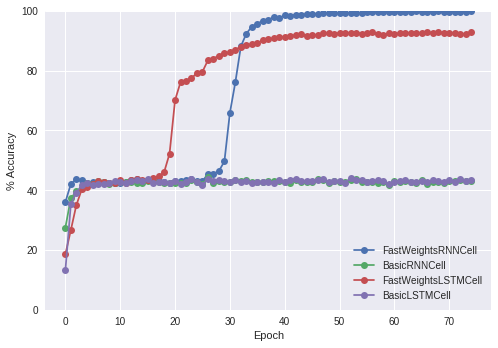

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_ylabel('% Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim([0, 100.])
for name, accuracies in [(cell.__class__.__name__, train_fn(cell)) 
                         for cell in cells]:
  ax.plot(accuracies, marker='o', label=name)
_ = ax.legend(loc='lower right', shadow=True)